In [1]:
import pandas as pd
import numpy as np
import string
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import json
import os

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/loubly211/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /home/loubly211/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/loubly211/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/loubly211/nltk_data...


In [2]:
#chemin des fichiers csv
csv_path = "../../data/cleaned/data1_cleaned.csv"
csv2_path = "../../data/cleaned/data2_cleaned.csv"

In [3]:
current_dir = os.getcwd()
json_path = os.path.join(current_dir, "../../ressources/acronym.json")
# Charger le fichier JSON contenant les acronymes
with open("../../ressources/acronym.json", "r") as f:
    acronym_definitions = json.load(f)

def acronym_means(text):
    new_text = []
    for i in text.split():
        if i in acronym_definitions:
            new_text.append(acronym_definitions[i])
        else:
            new_text.append(i)
    return " ".join(new_text)

In [4]:
#definition des stopwords et Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [5]:
# Fonction pour convertir en minuscules
def to_lowercase(text):
    return text.lower()

In [6]:
# Fonction pour supprimer la ponctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [7]:
# Fonction pour supprimer les stopwords et appliquer la lemmatisation
def remove_stopwords_and_lemmatize(text):
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

In [8]:
import re
def remove_xxx(text):
    # Supprimer tous les chiffres qui ne sont PAS suivis de "cm"
    text = re.sub(r'\b\d+\b(?!\s*cm\b)', '', text)
    text = text.replace("xxxx", "anonym").replace("x", "")
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [9]:
# Fonction pour générer des n_grame (trigrams)
def generate_n_grams(text, min_count=1, threshold=1):
    
    if isinstance(text, str):
        # Diviser le texte en tokens
        corpus = [text.split()]
    else:
        raise ValueError("Le texte d'entrée doit être une chaîne de caractères.")

    # Modèle de bigrammes
    bigram_model = Phrases(corpus, min_count=min_count, threshold=threshold)
    bigrams = [bigram_model[doc] for doc in corpus]

    # Modèle de trigrammes
    trigram_model = Phrases(bigrams, min_count=min_count, threshold=threshold)
    trigrams = [trigram_model[doc] for doc in bigrams]

    # Conversion en trigrammes
    result = []
    for doc in trigrams:
        for gram in doc:
            if "_" in gram: 
                result.append(gram)
            else:
                result.append(gram)  # Garder les mots non reliés
    return ' '.join(result)

In [10]:
# Fonction principale de prétraitement pour une colonne de texte
def preprocess_text_column(column):
    try:
        column = column.astype(str)
        column = column.apply(remove_punctuation)
        column = column.apply(acronym_means)
        column = column.apply(to_lowercase)
        column = column.apply(remove_stopwords_and_lemmatize)
        column = column.apply(remove_xxx)
        column = column.apply(generate_n_grams)
        return column
    except Exception as e:
        print("Erreur dans le prétraitement :", e)
        return None

In [11]:
#fonction pour combiner des columns
def combine_columns(df, text_columns):
    """
    Combine les colonnes spécifiées d'un DataFrame en une seule colonne nommée 'combined_text',
    puis supprime toutes les autres colonnes.
    Retourne un DataFrame ne contenant que la colonne combinée.
    """
    try:
        # Combiner les colonnes spécifiées dans une seule chaîne de texte par ligne
        df['combined_text'] = df[text_columns].fillna('').astype(str).agg(' '.join, axis=1)
        # Ne conserver que la colonne combinée
        df = df[['combined_text']]
        return df
    except Exception as e:
        print("Erreur lors de la combinaison des colonnes :", e)
        return None


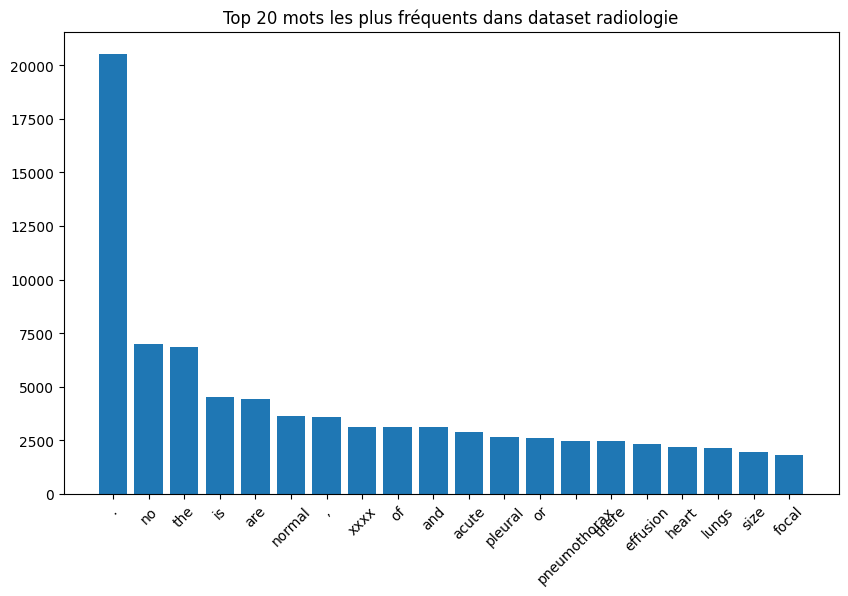

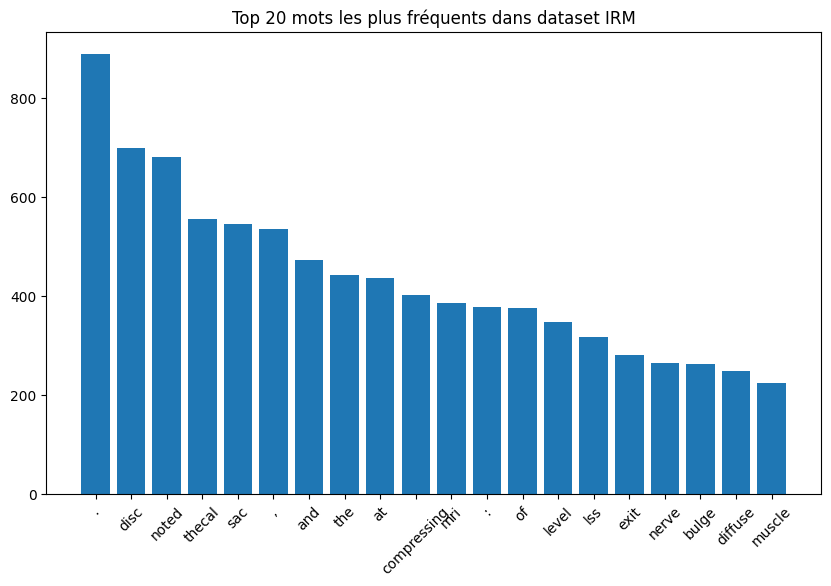

In [12]:
#afficher le graphe de fréquence des mots(pour voir si on supprime des mots en plus des stopwords)
df1 = pd.read_csv(csv_path)
df2 = pd.read_csv(csv2_path)
text_columns = ['abstract_FINDINGS', 'abstract_IMPRESSION']
combine_columns(df1, text_columns)
texts1 = df1['combined_text'].dropna()
texts2 = df2["Clinician's Notes"].dropna()

def calculate_and_plot_frequencies(texts, dataset_name, n=50):
    all_text = " ".join(texts.str.lower())
    tokens = word_tokenize(all_text)
    freq_dist = nltk.FreqDist(tokens)

    # Affichage du graphe
    most_common_words = freq_dist.most_common(n)
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(f'Top {n} mots les plus fréquents dans {dataset_name}')
    plt.show()

    return freq_dist
    
freq1 = calculate_and_plot_frequencies(texts1,"dataset radiologie", n=20)
freq2 = calculate_and_plot_frequencies(texts2,"dataset IRM", n=20) 

In [15]:

def preprocess_dataframe(df, column_text='combined_text'):
    """
    Applique le prétraitement sur une colonne spécifique du DataFrame (par défaut 'combined_text').

    Args:
        df (DataFrame): Le DataFrame contenant les données à traiter.
        column_text (str): Le nom de la colonne à traiter (par défaut 'combined_text').

    Returns:
        tuple: (bool, DataFrame ou None) :
               - True et le DataFrame traité si le prétraitement réussit.
               - False et None en cas d'échec.
    """
    try:
        if column_text not in df.columns:
            print(f"Erreur : La colonne '{column_text}' est manquante dans le DataFrame.")
            return False, None

        # Appliquer le prétraitement sur la colonne spécifiée
        df[column_text] = preprocess_text_column(df[column_text])

        if df[column_text].isnull().all():
            print("Erreur : Le prétraitement a échoué, aucune donnée valide.")
            return False, None

        print("Prétraitement réussi.")
        return True, df

    except Exception as e:
        print(f"Erreur dans le prétraitement global : {e}")
        return False, None



In [16]:
def execute_pipeline(csv_path, csv2_path, text_columns):
    """
    Exécute le pipeline complet de combinaison des fichiers, prétraitement des données,
    et renvoi du DataFrame traité ou d'un message d'erreur.

    Args:
        csv_path (str): Chemin vers le fichier CSV.
        csv2_path (str): Chemin vers le deuxième fichier CSV.
        text_columns (list): Colonnes à combiner dans le DataFrame CSV.

    Returns:
        tuple: Deux DataFrames prétraités si tout se passe bien.
    """
    try:
        # Charger les fichiers CSV
        data1 = pd.read_csv(csv_path)
        data2 = pd.read_csv(csv2_path)

        # Étape 1 : Vérifier si les fichiers sont bien chargés
        if data1.empty or data2.empty:
            print("Erreur : l'un des fichiers CSV est vide.")
            return None, None

        # Étape 2 : Copier les données
        new_data1 = data1.copy()
        new_data2 = data2.copy()

        # Étape 3 : Combiner les colonnes spécifiées dans text_columns
        new_data1 = combine_columns(new_data1, text_columns)
        if new_data1 is None:
            print("Erreur lors de la combinaison des colonnes dans data1.")
            return None, None

        # Étape 4 : Prétraiter les données
        success1, new_data1 = preprocess_dataframe(new_data1, column_text='combined_text')
        success2, new_data2 = preprocess_dataframe(new_data2, column_text="Clinician's Notes")

        if not success1 or not success2:
            print("Erreur : le prétraitement a échoué.")
            return None, None

        # Étape 5 : Vérifier et nettoyer les données (par exemple, suppression des lignes vides)
        new_data1.dropna(subset=['combined_text'], inplace=True)
        new_data2.dropna(subset=["Clinician's Notes"], inplace=True)

        print("Le pipeline complet a réussi.")
        return new_data1, new_data2

    except Exception as e:
        print(f"Une erreur s'est produite dans le pipeline : {e}")
        return None, None



In [17]:
text_columns = ['abstract_FINDINGS', 'abstract_IMPRESSION']
final_data1, final_data2 = execute_pipeline(csv_path, csv2_path, text_columns)
final_data1.to_csv('../../data/cleaned/final_clean_data1.csv', index=False)
final_data2.to_csv('../../data/cleaned/final_clean_data2.csv', index=False)

Prétraitement réussi.
Prétraitement réussi.
Le pipeline complet a réussi.


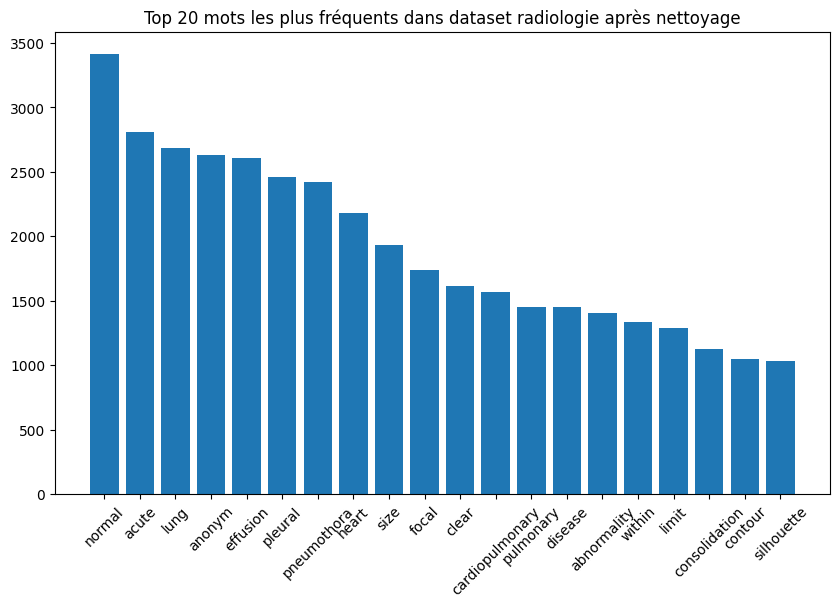

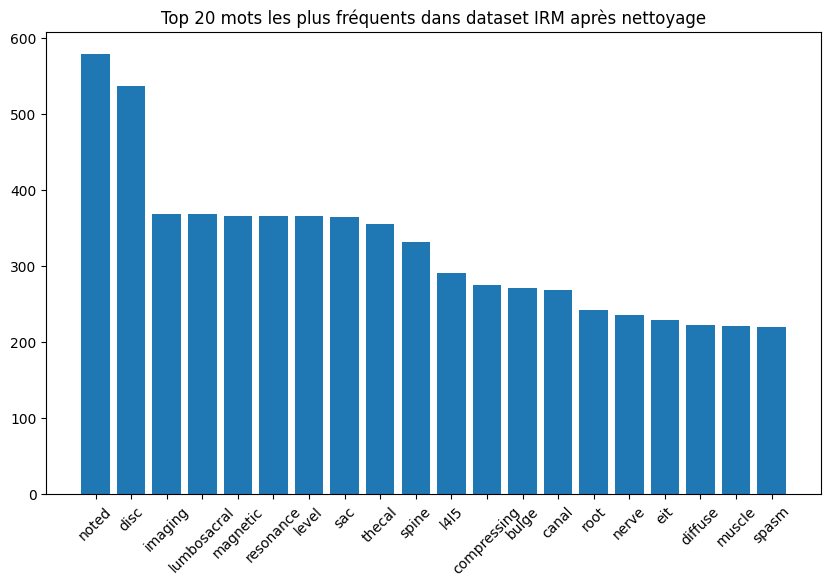

In [18]:
text1 = final_data1['combined_text']
text2 = final_data2["Clinician's Notes"]
freq1 = calculate_and_plot_frequencies(text1,"dataset radiologie après nettoyage", n=20)
freq2 = calculate_and_plot_frequencies(text2,"dataset IRM après nettoyage", n=20)

In [19]:
# Densité des points dans les dimensions de l'espace des plongements lexicaux
def estimate_density(x_vals, y_vals, bandwidth=0.1):
    """
    Estime la densité des points à l'aide du Kernel Density Estimation (KDE) dans le but de pouvoir donner un zoom 
    de la visualisation des points.
    :param x_vals: Liste des valeurs de la dimension 1
    :param y_vals: Liste des valeurs de la dimension 2
    :param bandwidth: Paramètre du noyau KDE, plus petit = plus précis, plus grand = plus lisse
    :return: Coordonnées de la zone de densité élevée
    """
    # Empile les valeurs x et y pour l'estimation KDE
    points = np.vstack([x_vals, y_vals]).T

    # KDE pour estimer la densité
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(points)
    
    # Calcul des densités pour une grille de points
    x_grid = np.linspace(min(x_vals), max(x_vals), 100)
    y_grid = np.linspace(min(y_vals), max(y_vals), 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([X.ravel(), Y.ravel()]).T
    densities = np.exp(kde.score_samples(grid_points))

    # Trouver la région la plus dense
    max_density_index = np.argmax(densities)
    max_density_point = grid_points[max_density_index]

    return max_density_point, densities.reshape(X.shape)


In [20]:
def visualisation_with_zoom(x_vals, y_vals, labels, zoom=True, bandwidth=0.1):
    """
    Affiche un nuage de points avec un zoom automatique sur la zone la plus dense.
    :param x_vals: Liste des valeurs de la dimension 1
    :param y_vals: Liste des valeurs de la dimension 2
    :param labels: Liste des labels pour chaque point
    :param zoom: Booléen indiquant si un zoom doit être effectué (par défaut True)
    :param bandwidth: Paramètre de l'estimation de la densité
    """
    # Affichage du premier graphique sans zoom
    plt.figure(figsize=(16, 16))
    plt.scatter(x_vals, y_vals, alpha=0.7, s=50)
    plt.grid(visible=True, linestyle="--", linewidth=0.5, alpha=0.7)
    for i in range(len(labels)):
        plt.annotate(
            labels[i],
            (x_vals[i], y_vals[i]),
            fontsize=9,
            alpha=0.8,
            textcoords="offset points",
            xytext=(5, 5)
        )
    plt.title("Nuage de points des plongements lexicaux - Sans zoom", fontsize=16)
    plt.xlabel("Dimension 1", fontsize=14)
    plt.ylabel("Dimension 2", fontsize=14)
    plt.show()

    # Estimation de la densité
    max_density_point, densities = estimate_density(x_vals, y_vals, bandwidth)

    # Définir les limites du zoom autour de la zone de densité maximale
    zoom_limits = {
        'x': (max_density_point[0] - 1, max_density_point[0] + 1),
        'y': (max_density_point[1] - 1, max_density_point[1] + 1)
    }

    # Affichage avec zoom automatique basé sur la densité
    plt.figure(figsize=(16, 16))
    plt.scatter(x_vals, y_vals, alpha=0.7, s=50)

    # Si le zoom est activé, ajuster les limites
    if zoom:
        plt.xlim(zoom_limits['x'])  # Plage des valeurs pour la dimension 1
        plt.ylim(zoom_limits['y'])  # Plage des valeurs pour la dimension 2

    plt.grid(visible=True, linestyle="--", linewidth=0.5, alpha=0.7)
    for i in range(len(labels)):
        plt.annotate(
            labels[i],
            (x_vals[i], y_vals[i]),
            fontsize=9,
            alpha=0.8,
            textcoords="offset points",
            xytext=(5, 5)
        )
    plt.title("Nuage de points des plongements lexicaux - Avec zoom sur densité", fontsize=16)
    plt.xlabel("Dimension 1", fontsize=14)
    plt.ylabel("Dimension 2", fontsize=14)
    plt.show()




In [21]:
wv = api.load('glove-wiki-gigaword-300')

[===-----------------------------------------------] 6.2% 23.4/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 14.8% 55.7/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 24.0% 90.2/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================----------------------------------] 33.1% 124.6/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 42.3% 159.1/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 51.4% 193.4/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 60.5% 227.4/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 68.5% 257.7/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================================------------] 76.9% 289.2/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================================--------] 85.9% 323.1/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 94.3% 354.8/376.1MB downloaded


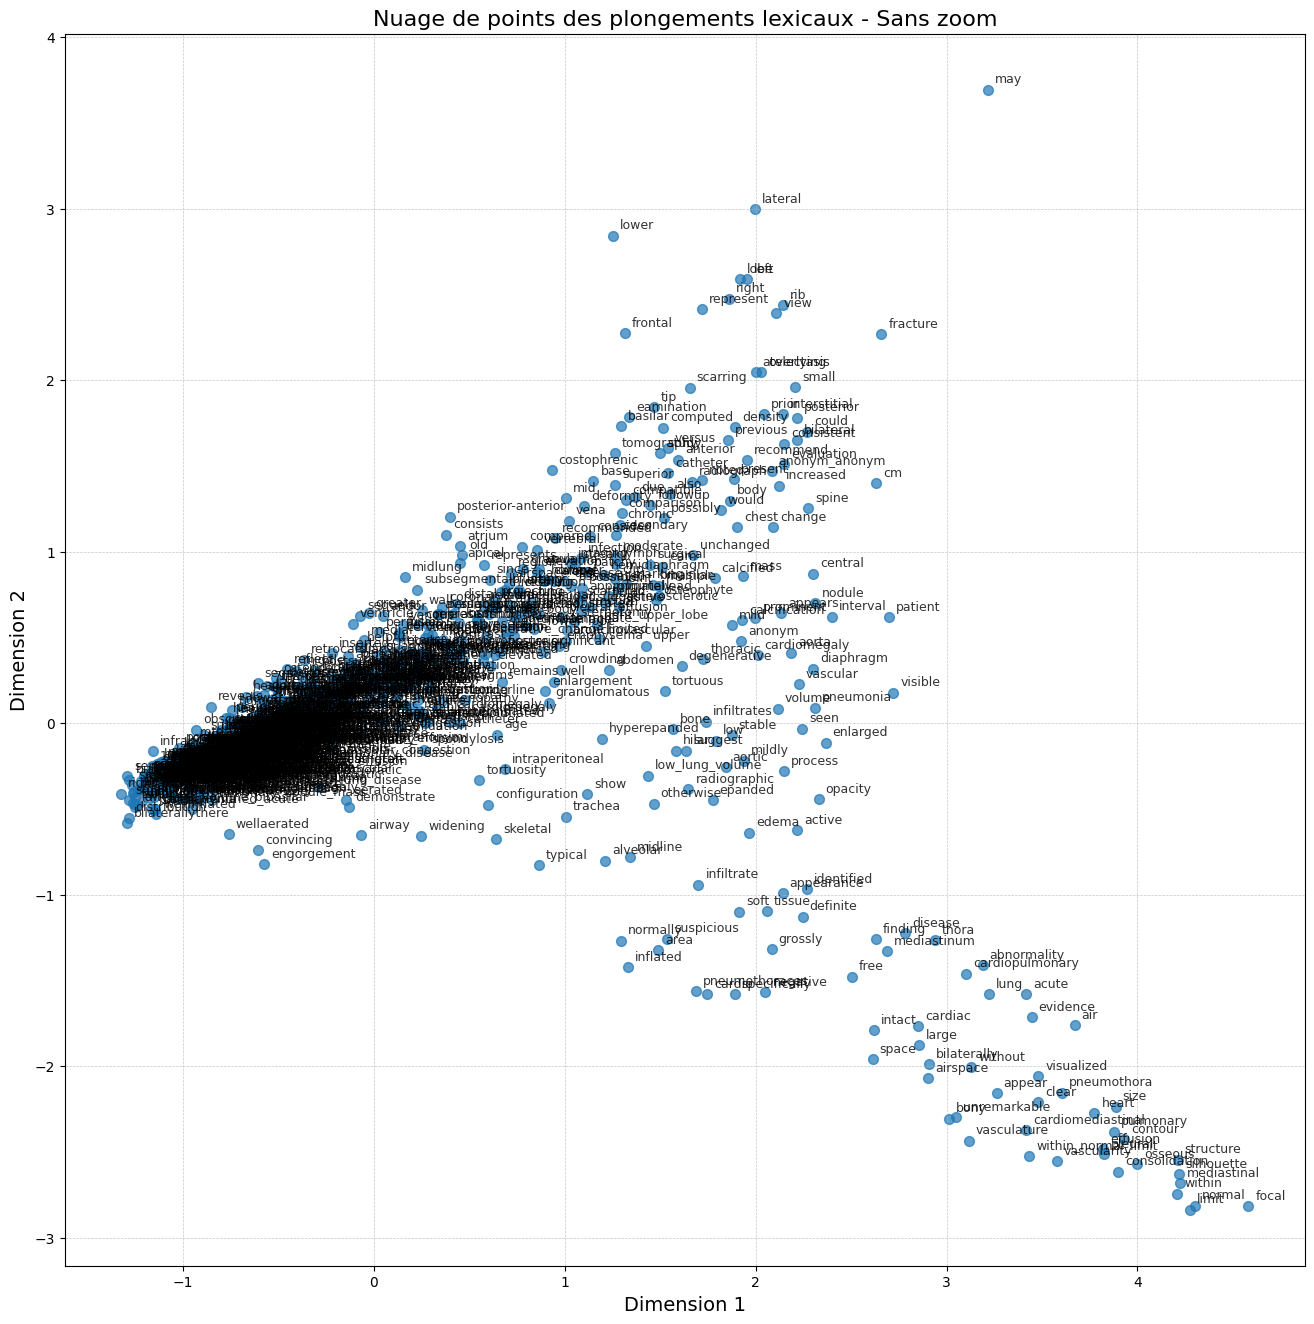

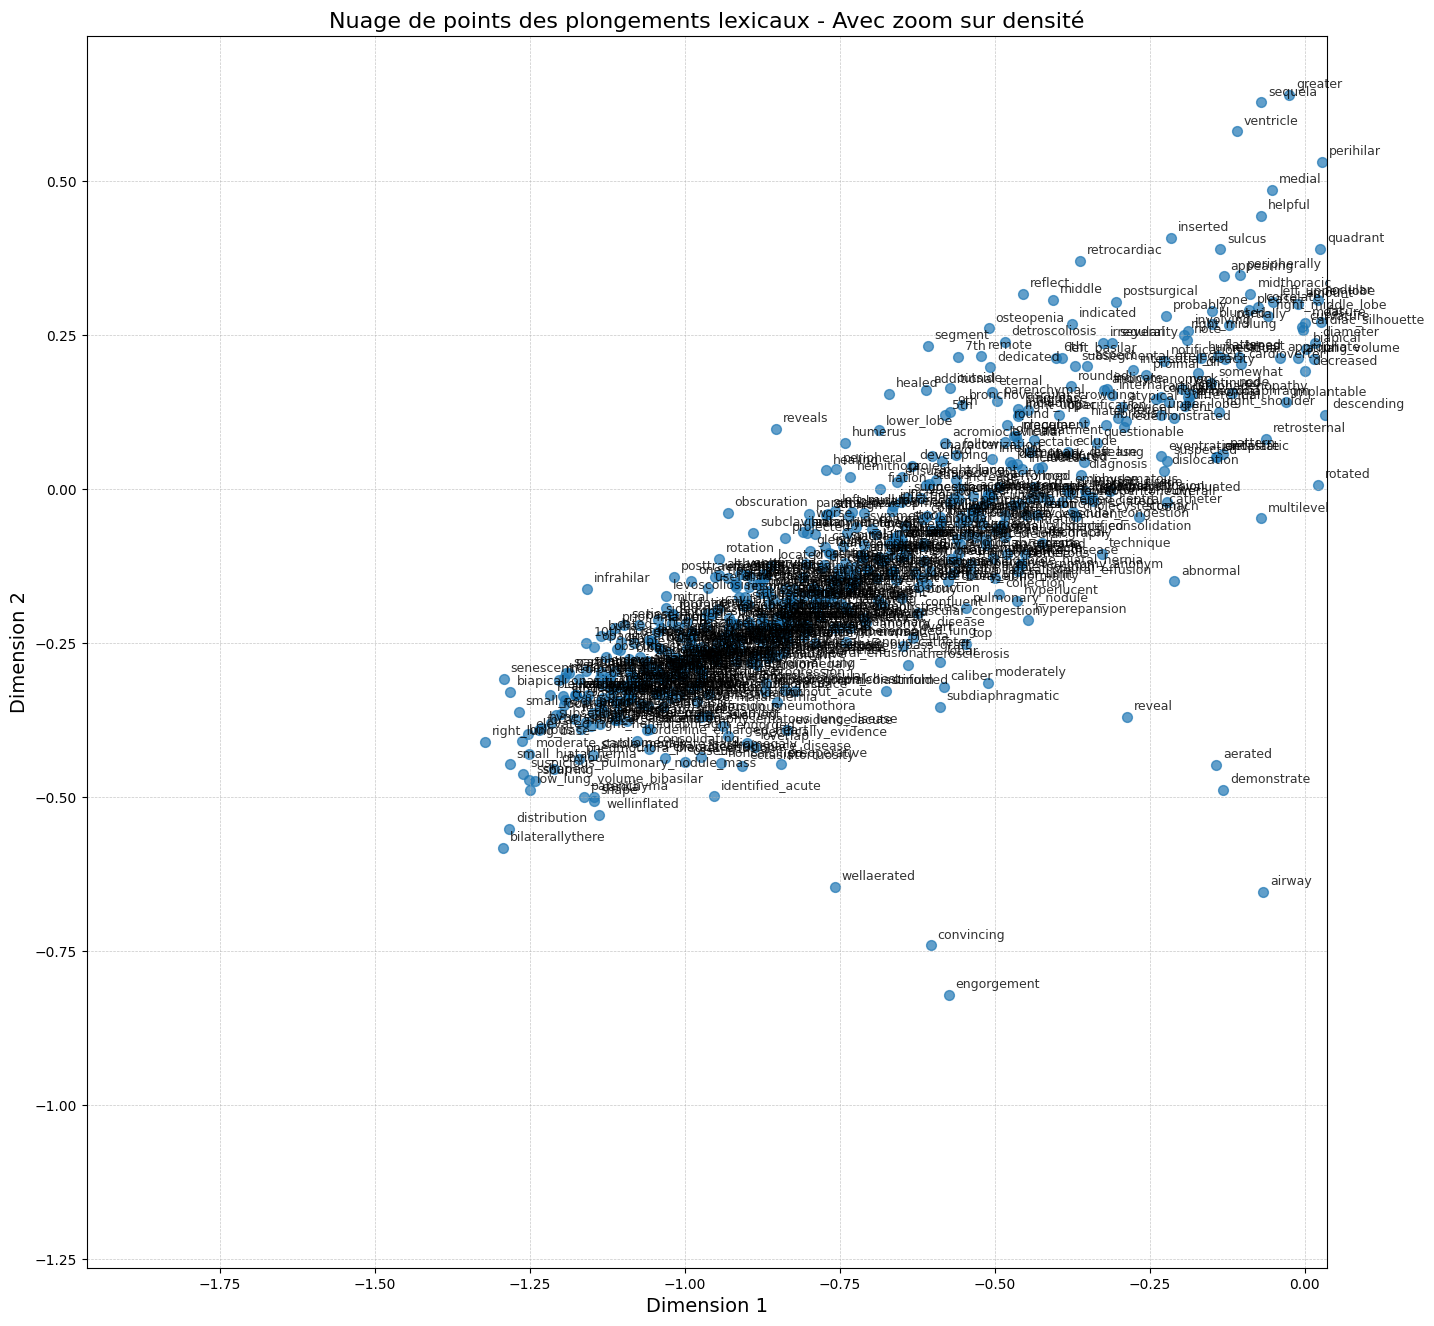

In [22]:
def reduce_dimensions_pca(wv, n):
    num_dimensions = 2  # réduction à 2 dimensions
    # Extraire les vecteurs et labels
    vectors = np.asarray(wv.vectors[:n])
    labels = np.asarray(wv.index_to_key[:n])
    # Réduction avec PCA
    pca = PCA(n_components=num_dimensions)
    vectors = pca.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels
def print_visualisation(data,col,zoom=True):
    tokenized_sentences = data[col].apply(word_tokenize)
    model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4) 
    x_vals_pca, y_vals_pca, labels_pca = reduce_dimensions_pca(model.wv, 1000)
    visualisation_with_zoom(x_vals_pca, y_vals_pca, labels_pca, zoom=zoom, bandwidth=0.1)
print_visualisation(final_data1,"combined_text")